# Differentiable Gauss-Newton in PyTorch

Efficiently and accurately computing the Jacobian and Hessian of a function can be a little tricky.

PyTorch now has higher-order function transforms which make it very easy to compute the Jacobian of a function. We can use these to build efficient optimization routines, such as Gauss-Newton and Levenberg-Marquadt, which compute approximations of the Hessian for better informed optimization.

In this notebook, I adapt an example from a biology experiment referenced on Wikipedia and test to see if we can achieve the same result. We then go a step further and add a stochastic outer-optimization loop to try to find the optimal step size / damping parameter for this problem.

https://en.wikipedia.org/wiki/Gauss–Newton_algorithm#Example

In [2]:
import torch
from functorch import jacfwd, jacrev

First, create our data.

In [5]:
concentration = torch.tensor([0.038, 0.194, 0.425, 0.626, 1.253, 2.5, 3.74])
rate = torch.tensor([0.05, 0.127, 0.094, 0.2122, 0.2729, 0.2665, 0.3317])

Define a residual function to evaluate the fitness of our model parameters, $\beta$

In [3]:
def residuals(betas):
    b1, b2 = betas
    return rate - (b1 * concentration) / (b2 + concentration)

Our optimizer requires that we are able to compute the Jacobian with respect to the model parameters.

We can create this function automatically using function composition. `jacfwd`, takes our `residuals` function and returns a new function which computes the jacobians with respect to the first argument.

https://pytorch.org/functorch/stable/generated/functorch.jacrev.html#functorch.jacrev

https://pytorch.org/functorch/stable/generated/functorch.jacfwd.html#functorch.jacfwd

In [4]:
# Which is better?
# jac_residuals = jacfwd(residuals)
jac_residuals = jacrev(residuals)

Below is an extremely simple gauss newton optimization routine, which just runs for a fixed number of iterations.

Because the number of iterations is always fixed, we can avoid writing any code that deals with numerical stopping criteria.

In [5]:
def gauss_newton(x, residuals, jac_residuals, damping=1., iterations=5):
    # Unroll a number of iterations of Gauss-Newton.
    for i in range(0, iterations):
        # Compute the gauss-newton updates.
        # We cannot easily backpropagate through computing the Jacobian. However, we don't need to.
        # Here, we temporarily disconnect from the computation graph, and then re-attach at each iteration.
        with torch.no_grad():
            r = residuals(x)
            J = jac_residuals(x)
            # https://en.wikipedia.org/wiki/Gauss–Newton_algorithm
            u = torch.linalg.lstsq(J.T @ J, J.T @ r).solution
        # Update x, and in doing so, connect the update step to the computation graph.
        # This allows an outer optimization loop to compute the derivative of the loss with respect to the inputs.
        x = x - damping * u
    return x

We can now check if our implementation is correct. From Wikipedia:

> Starting with the initial estimates of $\beta_{1}=0.9$ and $\beta _{2}=0.2$, after five iterations of the Gauss–Newton algorithm, the optimal values $\hat{\beta }_{1}=0.362$ and $\hat{\beta}_{2}=0.556$ are obtained.

In [6]:
# Does our optimized value match wikipedia?
betas = torch.tensor([0.9, 0.2])
b_hat = gauss_newton(betas, residuals, jac_residuals, damping=1)
print(b_hat)

tensor([0.3618, 0.5561])


We can now go a step further and try to optimize the `damping` parameter, because we added some tricks to make the optimization itself end-to-end differentiable.

We will do this by running our differentiable optimizer with the same initial guess, and minimizing the residuals after 5 iterations.

In [7]:
from torch.optim import Adam

damping = torch.tensor(1.0, requires_grad=True)

optimizer = Adam([damping], lr=0.1)

loss_history = []
for i in range(0, 10):
    optimizer.zero_grad()
    guess = torch.tensor([0.9, 0.2])
    betas = gauss_newton(guess, residuals, jac_residuals, damping=damping, iterations=5)
    loss = torch.mean(residuals(betas) ** 2)
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()

In [8]:
print(damping)
print(betas)

tensor(0.9868, requires_grad=True)
tensor([0.3617, 0.5557], grad_fn=<SubBackward0>)


Does an optimized damping parameter improve on the results of our residuals?

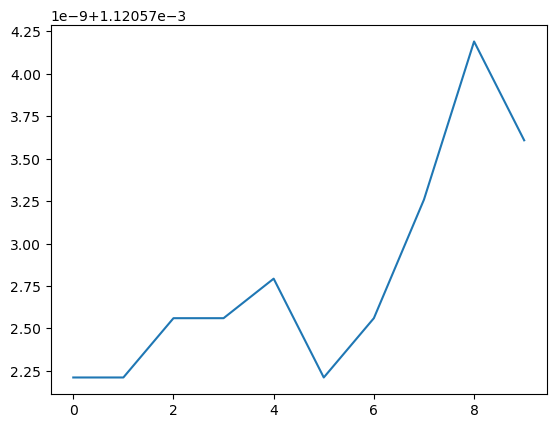

In [480]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()